# Network-based Gene Prioritization from GWAS Data
MED283: Network Biology & Biomedicine  
Nadia Arang & Kevin Chau

In [1]:
%matplotlib inline

import ndex2
import networkx as nx
from networkx.algorithms import community
import pandas as pd
import numpy as np
from scipy.stats import linregress
import random
import matplotlib.pyplot as plt
import math

## Initial data loading

In [2]:
# Load pcnet from server
pc_nice = ndex2.create_nice_cx_from_server(server = "http://public.ndexbio.org", 
                                           uuid = "f93f402c-86d4-11e7-a10d-0ac135e8bacf")

In [3]:
# Cast as networkx object
# First cast to pandas since networkx 2.1 is incompatible with ndex2
pc_pd = pc_nice.to_pandas_dataframe()
pcnet = nx.from_pandas_edgelist(pc_pd)

In [4]:
# Load gene summary table
gene_summaries = pd.read_csv("../src/gene_level_summary_stats_pmid_25056061.txt", 
                             header = 0, sep = '\t', index_col = 1)
gene_summaries.head()

,Unnamed: 0,Chr,Gene Start,Gene End,nSNPs,TopSNP,TopSNP Pos,TopSNP P-Value,SNP Distance
Gene,,,,,,,,,
HIST1H4K,5905,6,27906930,27907284,8,rs34706883,27913234.0,5.071180e-10,6304.0
HIST1H2AK,5867,6,27913636,27914096,16,rs34706883,27913234.0,5.071180e-10,402.0
HIST1H2BN,5883,6,27914418,27914867,17,rs34706883,27913234.0,5.071180e-10,1184.0
HIST1H2AL,5868,6,27941085,27941555,10,rs13199772,27942064.0,7.053790e-10,979.0
HIST1H1B,5855,6,27942548,27943338,10,rs13199772,27942064.0,7.053790e-10,484.0


In [5]:
# Load snp summary table
snp_summaries = pd.read_csv("../src/snp_level_summary_stats_pmid_25056061.txt", 
                            header = 0, sep = '\t', index_col = 0, na_values = ".")
snp_summaries.head()

,hg18chr,bp,a1,a2,or,se,pval,info,ngt,CEUaf
snpid,,,,,,,,,,
rs3131972,1,742584,A,G,1.0257,0.0835,0.761033,0.1613,0,0.160550
rs3131969,1,744045,A,G,1.0221,0.0801,0.784919,0.2225,0,0.133028
rs3131967,1,744197,T,C,1.0227,0.0858,0.793520,0.2060,0,NaN
rs1048488,1,750775,T,C,0.9749,0.0835,0.761041,0.1613,0,0.836449
rs12562034,1,758311,A,G,1.0011,0.0756,0.987899,0.1856,3,0.092593


In [123]:
pclap = nx.laplacian_matrix(pcnet)

In [65]:
gene_summaries["TopSNP OR"] = gene_summaries.apply(lambda r: snp_summaries.loc[r["TopSNP"], "or"], axis = 1)

### Adding information to the network

In [66]:
nx.set_node_attributes(pcnet, values = gene_summaries.T.to_dict())

## Community detection

Detect communities within PCNet and perform predictions on those communities

## Spectral clustering

In [101]:
pc_adj = pd.DataFrame(nx.adjacency_matrix(pcnet).toarray())
pc_adj_mat = pc_adj

In [102]:
pc_adj.columns = pcnet.nodes
pc_adj.index = pcnet.nodes

In [96]:
pc_adj.head()

,UBE2Q1,RNF14,UBE2Q2,TMCO1,UBAC1,WWP1,ZNF706,MIB2,RNF114,RNF115,...,TMEM26,RAD51AP2,AC010422.6,PLEKHA8P1,CD300LD,BAGE4,FAM181B,IGFL3,BAT4,TPT1P8
UBE2Q1,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
RNF14,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
UBE2Q2,1,1,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
TMCO1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
UBAC1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
from sklearn.cluster import SpectralClustering

In [127]:
sc = SpectralClustering(eigen_solver = "amg")

In [128]:
sc.fit_predict(pc_adj_mat)

/usr/local/lib/python3.6/site-packages/sklearn/cluster/spectral.py:442: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
/usr/local/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


KeyboardInterrupt: 

## Naive Bayes

In [109]:
from sklearn.naive_bayes import GaussianNB

In [110]:
model = GaussianNB()

In [118]:
model.fit(pc_adj_mat, y = gene_class)

GaussianNB(priors=None)

In [122]:
model.predict(np.array([1,0,1,0,1,0,1,1,1,0]).reshape(-1, 1))

array([0, 1, 0, 1, 0, 1, 0, 0, 0, 1])

## PCA


In [129]:
from sklearn.decomposition import PCA

In [130]:
pca = PCA(n_components = 2)

In [143]:
pca.fit(pd.DataFrame(pclap.toarray()))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [144]:
pca.explained_variance_

array([5099.19036741,  659.95082241])

In [138]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [148]:
proj = pca.fit_transform(pd.DataFrame(pclap.toarray()))

In [149]:
proj.shape

(19781, 2)

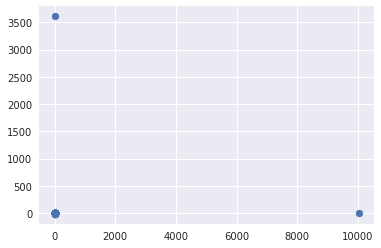

In [150]:
plt.scatter(proj[:, 0], proj[:, 1])

In [151]:
pclap_df = pd.DataFrame(pclap.toarray())

In [152]:
pclap_df.head()

,0,1,2,3,4,5,6,7,8,9,...,19771,19772,19773,19774,19775,19776,19777,19778,19779,19780
0,364,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,0,0,0,0,0,0,0,0,0,0
1,-1,603,-1,-1,0,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-1,-1,400,0,-1,-1,-1,-1,-1,-1,...,0,0,0,0,0,0,0,0,0,0
3,-1,-1,0,634,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-1,0,-1,0,415,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [159]:
[_ for _ in proj if _[0] > 3000]

[array([1.00424999e+04, 9.83019865e-02])]

## Random walks

Calculate stochastic matrix for PCNet using gene p-values as personalization vector

In [16]:
pc_google = nx.google_matrix(pcnet, personalization = genes_p)

In [17]:
pcg_df = pd.DataFrame(pc_google)

In [18]:
pcg_df.head()

,0,1,2,3,4,5,6,7,8,9,...,19771,19772,19773,19774,19775,19776,19777,19778,19779,19780
0,0.000005,0.002339,0.002363,2.336161e-03,0.002345,0.002350,0.002344,0.002372,0.002341,0.002344,...,0.000005,0.000021,0.0,0.0,0.000001,0.0,0.00003,0.000005,0.0,0.0
1,0.001414,0.000004,0.001437,1.410615e-03,0.000010,0.001424,0.000009,0.000037,0.000006,0.000008,...,0.000005,0.000021,0.0,0.0,0.000001,0.0,0.00003,0.000005,0.0,0.0
2,0.002130,0.002129,0.000028,9.960562e-07,0.002135,0.002140,0.002134,0.002162,0.002131,0.002133,...,0.000005,0.000021,0.0,0.0,0.000001,0.0,0.00003,0.000005,0.0,0.0
3,0.001345,0.001345,0.000028,9.960562e-07,0.000010,0.000015,0.000009,0.000037,0.000006,0.000008,...,0.000005,0.000021,0.0,0.0,0.000001,0.0,0.00003,0.000005,0.0,0.0
4,0.002053,0.000004,0.002076,9.960562e-07,0.000010,0.000015,0.000009,0.000037,0.000006,0.000008,...,0.000005,0.000021,0.0,0.0,0.000001,0.0,0.00003,0.000005,0.0,0.0


Update signal values

In [9]:
### TEST
pers = genes_p
potential_causal = [g for g in pers if g in pcnet.nodes and pers[g] <= 0.00000005]
cur_net = pcnet
for i in range(1):
    print("Iteration {}".format(str(i)))
    print("Construct stochastic matrix")
    pc_goog = nx.google_matrix(cur_net, personalization = genes_p)
    pc_go_df = pd.DataFrame(pc_goog)
    pc_go_df.columns = pcnet.nodes
    pc_go_df.index = pcnet.nodes
    random_causal = random.choice(potential_causal)
    
    print("Rescoring")
    pers = {_: pc_go_df.loc[random_causal, _] * pers[_] for _ in pers if _ in pcnet.nodes}
    potential_causal = [g for g in pers if pers[g] <= 0.00000005]
    
    #print("Recalculating network")
    #cur_net = nx.from_pandas_adjacency(pc_go_df)

Iteration 0
Construct stochastic matrix
Rescoring


In [10]:
pers

{'HIST1H4K': 2.4518253521387577e-23,
 'HIST1H2AK': 2.4518253521387577e-23,
 'HIST1H2BN': 2.4518253521387577e-23,
 'HIST1H2AL': 4.743692527222043e-23,
 'HIST1H1B': 4.743692527222043e-23,
 'HIST1H3I': 4.743692527222043e-23,
 'HIST1H4L': 4.743692527222043e-23,
 'PGBD1': 1.4565873373864755e-22,
 'HIST1H1E': 2.0269642982848165e-22,
 'HIST1H2BD': 2.0269642982848165e-22,
 'ZKSCAN4': 3.071647332107347e-22,
 'ZSCAN12': 3.747651576096901e-22,
 'ZNF165': 1.625112412296277e-21,
 'NKAPL': 2.4169461758804426e-21,
 'OR2B2': 9.929789762342573e-21,
 'NT5C2': 4.7483541882410984e-20,
 'ZSCAN23': 6.986363845051025e-20,
 'EI24': 8.077025434268149e-20,
 'ZNF184': 1.5478948860819115e-19,
 'ZKSCAN3': 5.853580436935267e-10,
 'MAD1L1': 2.442020485204108e-19,
 'CNNM2': 3.89793329588102e-19,
 'AS3MT': 1.6137865861836847e-18,
 'STT3A': 2.164768821688007e-18,
 'CHEK1': 3.067610035643046e-18,
 'HIST1H2BL': 5.557587726449707e-18,
 'HIST1H3H': 5.557587726449707e-18,
 'HIST1H2AJ': 5.557587726449707e-18,
 'HIST1H2BM': 5

In [11]:
len([g for g in genes_p if genes_p[g] <= 0.00000005])

20

In [12]:
len([g for g in pers if pers[g] <= 0.00000005])

4609

## Something else

In [67]:
# Init working network
tmpnet = pcnet

In [48]:
# Get rank of nodes according to pagerank
ranks = nx.pagerank(tmpnet, nx.get_node_attributes(tmpnet, "TopSNP P-value"))

TypeError: unsupported operand type(s) for *: 'dict' and 'int'

In [ ]:
# Initialize randomized seed node array according to GWAS significance
causal_seeds = random.shuffle([g for g in tmpnet.nodes 
                               if "TopSNP P-value" in tmpnet.nodes[g].keys() 
                               and tmpnet.nodes[g]["TopSNP P-value"] <= 0.00000005])

In [ ]:
for seed in causal_seeds:
    nx.neighbors

## Odds ratio

In [80]:
def postOR(network, node):
    this_neighbors_p = [2 * network.nodes[nb]["TopSNP P-value"] - 1
                        for nb in nx.neighbors(network, node) 
                        if "TopSNP P-value" in network.nodes[nb].keys()]
    try:
        logodds = math.log(network.nodes[node]["TopSNP OR"])
    except ValueError:
        logodds = 0
    postodds = sum(this_neighbors_p) + logodds
    return(postodds)

In [81]:
reprioritizations = {gene: postOR(pcnet, gene) for gene in pcnet.nodes if "TopSNP OR" in pcnet.nodes[gene].keys()}

In [82]:
reprioritizations

{'UBE2Q1': 0.05515084446484802,
 'RNF14': -0.04646287441034086,
 'UBE2Q2': 0.04286790022717587,
 'TMCO1': -4.254513314374922,
 'UBAC1': -0.038013442198216174,
 'WWP1': 0.051548261880576554,
 'ZNF706': -0.03573080995579895,
 'MIB2': -0.5045122617093987,
 'RNF114': -0.042698754533115245,
 'RNF115': -4.057048777478403,
 'RNF111': -0.5220551057175394,
 'METTL13': 0.05363554916590934,
 'DHX8': 0.2600539053343068,
 'CBLB': -0.05508996631796001,
 'UBE4A': 0.07436508195530674,
 'DDX41': 0.1255748229080662,
 'ATMIN': 0.3747996937972793,
 'TSG101': -0.045415863530482575,
 'FBXW11': -0.08512225341683509,
 'UBE2D4': 0.11511280710050467,
 'RPS27A': -0.05097755476486746,
 'UBE2D2': -0.10502723786770594,
 'ATP6V1H': 0.2345977013593256,
 'UBE2D1': 6.225575535609677,
 'MFSD11': -5.472670753692815,
 'CCT3': -0.08066790306745482,
 'MRFAP1L1': -0.04301189059329105,
 'GTF2B': 0.07482914062064908,
 'FBXL13': 0.06541313854823212,
 'FBXL12': 0.09011488944226033,
 'FBXL15': -0.07450805217506158,
 'FBXL14': 1.4

In [110]:
pcnet.nodes["HIST1H4K"]

{'Pvalue': 5.07118e-10,
 'Unnamed: 0': 5905,
 'Chr': 6,
 'Gene Start': 27906930,
 'Gene End': 27907284,
 'nSNPs': 8,
 'TopSNP': 'rs34706883',
 'TopSNP Pos': 27913234.0,
 'TopSNP P-Value': 5.071180000000001e-10,
 'SNP Distance': 6304.0,
 'TopSnp OR': 1.2568,
 'TopSNP OR': 1.2568}

In [95]:
reprior_list = sorted(reprioritizations, key = lambda x: reprioritizations[x])[::-1]

In [98]:
reprior_list

['SERPINF1',
 'SERPINF2',
 'MIDN',
 'ADPRHL2',
 'TEKT2',
 'COL8A2',
 'KLHL17',
 'PLEKHN1',
 'NOC2L',
 'ACYP1',
 'SDF4',
 'DMBT1',
 'RAB11FIP1',
 'MRPS11',
 'SLC24A5',
 'CAPS',
 'RANBP3',
 'CDYL2',
 'USP6',
 'EPS8',
 'ZDHHC12',
 'CAPN14',
 'EHD3',
 'MYOZ1',
 'SYNPO2L',
 'LPCAT4',
 'GOLGA8A',
 'RASL10B',
 'GAS2L2',
 'PEAR1',
 'ACAP3',
 'SCNN1D',
 'ENTPD3',
 'PI4KB',
 'NPPA',
 'NFATC2',
 'TMEM138',
 'EIF4EBP1',
 'SSH3',
 'CLEC6A',
 'HIPK2',
 'NXNL1',
 'MTA1',
 'TMEM205',
 'MYEF2',
 'RGS1',
 'SOX12',
 'MLLT1',
 'SHARPIN',
 'MAF1',
 'CYC1',
 'UBE2D1',
 'PSME1',
 'PSME2',
 'RNF31',
 'DDB1',
 'LIFR',
 'DBP',
 'SPHK2',
 'NOL8',
 'CAPZA2',
 'RNASE2',
 'CAPN12',
 'ACTN4',
 'CABLES1',
 'CLDN7',
 'SLC2A4',
 'MAMDC4',
 'EDF1',
 'MORC1',
 'CXCL17',
 'CCDC97',
 'MRAP',
 'ALS2CL',
 'OR2W3',
 'LIG1',
 'ADPRHL1',
 'AADAT',
 'APOBEC3B',
 'UAP1L1',
 'LYPLA1',
 'GRB10',
 'GPR85',
 'ZDHHC4',
 'C7orf26',
 'SPEN',
 'ROMO1',
 'NFS1',
 'RBM39',
 'PRPF38B',
 'PTH1R',
 'SPATS2',
 'GCG',
 'NBPF1',
 'PCK2',
 'NRL',

In [113]:
reprior_list.index("ZKSCAN4")

13774

## Heat diffusion

With heat defined as p-value of top SNP per gene

### Random walk

In [114]:
pcnet_mat = nx.adjacency_matrix(pcnet)

In [116]:
init_pvec = [pcnet.nodes[_]["TopSNP P-Value"] 
             if "TopSNP P-Value" in pcnet.nodes[_] else 1
             for _ in pcnet.nodes]

In [ ]:
new_pvec = np.dot(pcnet_mat, init_pvec)

### Diffusion kernel

In [6]:
from scipy.linalg import expm

In [ ]:
alpha = ""

In [ ]:
new_pvec = np.dot(expm(-alpha * pclap), init_pvec)